# 文件分類

本次練習為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用聯合新聞網的三個版別文章做示範。

## 分析目標
+ 資料內容：
    + 資料來源：聯合新聞網
    + 版別：財經、社會、全球
    + 時間範圍：2024/01/01 ~ 2024/01/13
        + 聯合新聞網的版別：產經、股市、社會、國際、要聞
        + 聯合新聞網的產經版與股市版合併為財經版
            + 產經(produce)、股市(stock) -> 財經(economy)
        + 東森新聞網的版別：政治、社會、國際、財經
        + 東森新聞網的政治板對應到聯合新聞網的要聞板
            + 政治(politics) -> 要聞(news)

* 分析主題：將聯合新聞網三個版別的文章合起來，訓練模型能預測新聞版別，再用分類模型進行文件的版別分類。

* 以下為教學目標：
    1. 如何將以數字向量代表一篇文章？
        * `CountVectorizer`
        * `TfidfVectorizer`
    2. 基本的分類模型流程，包含以下三步驟：
        * 前處理 (preprocess)
        * 建模 (train model)
        * 評估與預測 (evaluation and predict)
    3. cross validation
    4. 不同分類器的效果
    5. 可解釋的可視化模型結果
    6. 預測其他家新聞文章的版別

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具  

In [41]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [42]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from matplotlib import font_manager

設定中文字體 

In [43]:
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


Text(0.5, 1.0, '聲量圖')

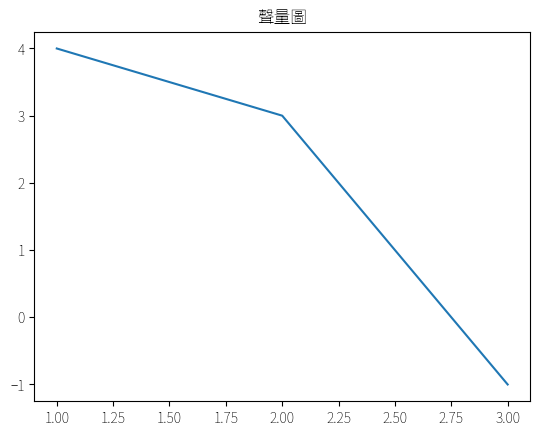

In [44]:
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")

# 2. 文字前處理
`聯合新聞.csv`裡面包含了要分析的 udn 新聞資料。
- 版別：全球(global)、社會(social)、產經(produce)、股市(stock)、要聞(important)
- 時間範圍：2024-01-01 ~ 2024-01-13 (總統大選前)
- 工作流程平台搜尋/排除關鍵字：無
 

In [45]:
# 文字前處理
udn = pd.read_csv("data/聯合日報最新.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,UDN
1,2,F-16V廠級維修能量今年第一季驗證 台美還在對峙談判中,2024/1/1 10:29,要聞,https://udn.com/news/story/10930/7678314,空軍2025年開始陸續接裝66架F-16C/D BLOCK70戰機，國防部軍備局表示，正透過...,UDN
2,3,義務役新兵看過來 入伍結訓震撼教育攻略圖表在這裡,2024/1/1 11:16,要聞,https://udn.com/news/story/10930/7678409,2024年1月首波徵召入營600名一年制兵役役男，這些役男入伍後，將接受新兵訓練震撼教育。國...,UDN


In [46]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 9480
date range: ('2024/1/1 0:05', '2024/1/9 9:59')
category: 
artCatagory
要聞    3551
產經    1806
全球    1795
股市    1232
社會    1096
Name: count, dtype: int64


**我們將聯合時報的產經版面與股市版面資料匯總，對應到東森新聞的財經版面**

In [47]:
udn.loc[udn['artCatagory'].isin(['產經', '股市']), 'artCatagory'] = '財經'

# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 9480
date range: ('2024/1/1 0:05', '2024/1/9 9:59')
category: 
artCatagory
要聞    3551
財經    3038
全球    1795
社會    1096
Name: count, dtype: int64


In [48]:
udn.to_csv('data/聯合新聞_merge.csv')

### 2.1 清理 

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。 

In [49]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,蔡總統主持元旦升旗國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,UDN
1,2,廠級維修能量今年第一季驗證台美還在對峙談判中,2024/1/1 10:29,要聞,https://udn.com/news/story/10930/7678314,空軍年開始陸續接裝架戰機國防部軍備局表示正透過談判爭取由漢翔建立廠級維修中心漢翔公司說維修中...,UDN
2,3,義務役新兵看過來入伍結訓震撼教育攻略圖表在這裡,2024/1/1 11:16,要聞,https://udn.com/news/story/10930/7678409,年月首波徵召入營名一年制兵役役男這些役男入伍後將接受新兵訓練震撼教育國防部說明震撼教育訓練場...,UDN


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。 

In [50]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,蔡總統主持元旦升旗國防部長邱國正率將領參加國防部表示蔡英文總統上午主持中華民國年元旦總統府升...,https://udn.com/news/story/10930/7678307,要聞
1,廠級維修能量今年第一季驗證台美還在對峙談判中空軍年開始陸續接裝架戰機國防部軍備局表示正透過談...,https://udn.com/news/story/10930/7678314,要聞
2,義務役新兵看過來入伍結訓震撼教育攻略圖表在這裡年月首波徵召入營名一年制兵役役男這些役男入伍後...,https://udn.com/news/story/10930/7678409,要聞
3,國防部籲法界嚴肅看待暴行抗命及聚眾鬥毆軍紀案因應兵役延長一年國防部今天表示已配合全國檢察長座...,https://udn.com/news/story/10930/7678652,要聞
4,暴行抗命等軍紀案國防部檢察官允速查嚴辦國軍已恢復一年制義務役外界關注是否恢復軍事審判制度國防...,https://udn.com/news/story/10930/7679055,要聞


In [51]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")

total docs: 9479


### 2.2 斷詞 

In [52]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [53]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [54]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

Building prefix dict from c:\Users\user\StockNatrakLanguageAnalyze\dict\dict.txt.big ...
Dumping model to file cache C:\Users\user\AppData\Local\Temp\jieba.u5ae90705fdb4b77be5322445f6354b39.cache
Loading model cost 1.556 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,蔡總統主持元旦升旗國防部長邱國正率將領參加國防部表示蔡英文總統上午主持中華民國年元旦總統府升...,https://udn.com/news/story/10930/7678307,要聞,總統 主持 元旦 升旗 國防部長 邱國 正率 將領 參加 國防部 表示 英文 總統 上午 主...
1,廠級維修能量今年第一季驗證台美還在對峙談判中空軍年開始陸續接裝架戰機國防部軍備局表示正透過談...,https://udn.com/news/story/10930/7678314,要聞,廠級 維修 能量 今年 第一季 驗證 台美還 對峙 談判 空軍 陸續 接裝架 戰機 國防部 ...
2,義務役新兵看過來入伍結訓震撼教育攻略圖表在這裡年月首波徵召入營名一年制兵役役男這些役男入伍後...,https://udn.com/news/story/10930/7678409,要聞,義務役 新兵 過來 入伍 結訓 震撼 教育 攻略 圖表 這裡 首波 徵召 入營 一年制 兵役...
3,國防部籲法界嚴肅看待暴行抗命及聚眾鬥毆軍紀案因應兵役延長一年國防部今天表示已配合全國檢察長座...,https://udn.com/news/story/10930/7678652,要聞,國防部 法界 嚴肅 看待 暴行 抗命 聚眾 鬥毆 軍紀 因應 兵役 延長 一年 國防部 今天...
4,暴行抗命等軍紀案國防部檢察官允速查嚴辦國軍已恢復一年制義務役外界關注是否恢復軍事審判制度國防...,https://udn.com/news/story/10930/7679055,要聞,暴行 抗命 軍紀 國防部 檢察官 速查 嚴辦 國軍 恢復 一年制 義務役 外界 關注 是否 ...


### 2.3 資料集基本檢視 

檢視資料內容

In [55]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

total posts: 9479
category: 
artCatagory
要聞    3550
財經    3038
全球    1795
社會    1096
Name: count, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。 

In [56]:
data = udn
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

4592    機構 全球 半導體 產能 增長 首破 每月 萬片 大關 集微網 消息 發佈 世界 晶圓廠 預...
7535    聯於 全球 首款 奈米 控制 最高 傳輸速度 每秒 控制 廠群 聯在 美西 時間 舉行 大展...
4833    彭博 評選 應該 關注 企業 台灣 一家 上榜 彭博 資訊 發布 應該 關注 全球 企業 包...
3259    國民黨 點名 戰犯 這是 合作 態度 總統 選舉 出爐 民進黨 總統 候選人 賴清德 當選 ...
1143    新泰 合法 房屋 自救 抗爭 市府 傲慢 得獎 國民黨 總統 候選人 侯友宜 先前 新北市 ...
Name: words, dtype: object
4592    全球
7535    財經
4833    全球
3259    要聞
1143    要聞
Name: artCatagory, dtype: object


In [57]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
要聞    37.451208
財經    32.049794
全球    18.936597
社會    11.562401
Name: proportion, dtype: float64

train percentage :
artCatagory
要聞    37.452901
財經    31.936699
全球    19.050490
社會    11.559910
Name: proportion, dtype: float64

test percentage :
artCatagory
要聞    37.447257
財經    32.313643
全球    18.670886
社會    11.568214
Name: proportion, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字

### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer 

In [58]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [59]:
X_train.head()

4592    機構 全球 半導體 產能 增長 首破 每月 萬片 大關 集微網 消息 發佈 世界 晶圓廠 預...
7535    聯於 全球 首款 奈米 控制 最高 傳輸速度 每秒 控制 廠群 聯在 美西 時間 舉行 大展...
4833    彭博 評選 應該 關注 企業 台灣 一家 上榜 彭博 資訊 發布 應該 關注 全球 企業 包...
3259    國民黨 點名 戰犯 這是 合作 態度 總統 選舉 出爐 民進黨 總統 候選人 賴清德 當選 ...
1143    新泰 合法 房屋 自救 抗爭 市府 傲慢 得獎 國民黨 總統 候選人 侯友宜 先前 新北市 ...
Name: words, dtype: object

In [60]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<6635x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 526461 stored elements in Compressed Sparse Row format>

In [61]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [62]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out()[:10])

['一些' '一名' '一天' '一定' '一家' '一年' '一度' '一早' '一次' '一直']


In [63]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一些']

{'機構': 549, '全球': 110, '半導體': 164, '產能': 624, '世界': 25, '報告': 263, '顯示': 983, '預計': 979, '首次': 988, '突破': 679, '計算': 802, '認為': 813, '包括': 158, '人工智慧': 55, '應用': 386, '晶片': 507, '需求': 967, '復甦': 375, '推動': 434, '項目': 974, '中國': 28, '大陸': 282, '統計': 709, '廠商': 353, '達到': 900, '將在': 308, '第二': 691, '地區': 253, '韓國': 973, '第三': 690, '日本': 494, '歐洲': 555, '產品': 622, '領域': 981, '增加': 265, '關鍵': 947, '因素': 236, '繼續': 725, '最高': 518, '時間': 503, '舉行': 754, '宣布': 301, '推出': 433, '製程': 789, '目前': 649, '未來': 529, '有望': 523, '表示': 786, '提升': 439, '最大': 513, '正式': 558, '包含': 157, '近期': 871, '智慧': 509, '系統': 699, '數位': 475, '健康': 93, '教育': 471, '科技': 674, '主要': 37, '企業': 71, '超過': 849, '國家': 240, '相關': 655, '新聞': 483, '追蹤': 872, '玩家': 614, '台灣': 198, '中心': 30, '規則': 793, '出爐': 129, '幾天': 350, '排隊': 430, '直接': 651, '這款': 881, '攻擊': 462, '二手': 48, '蘋果': 773, '注意': 582, '達人': 899, '檢查': 553, '避免': 912, '遊戲': 892, '最低': 512, '運動': 893, '折扣': 414, '曝光': 510, '友誼': 181, '破壞': 665, '西瓜': 791, '停售': 92, '限定'

0

In [64]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(6635, 1000)
(2844, 1000)


In [65]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

c:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [66]:
clf.classes_

array(['全球', '社會', '要聞', '財經'], dtype=object)

In [67]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['社會' '要聞' '社會' '全球' '財經' '財經' '要聞' '社會' '要聞' '要聞']


In [68]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(2844, 4)


array([3.36156079e-05, 9.99962888e-01, 2.14158965e-06, 1.35452247e-06])

In [69]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.94      0.95      0.94       531
          社會       0.97      0.97      0.97       329
          要聞       0.99      0.99      0.99      1065
          財經       0.99      0.98      0.98       919

    accuracy                           0.98      2844
   macro avg       0.97      0.97      0.97      2844
weighted avg       0.98      0.98      0.98      2844



In [70]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 505,    8,    6,   12],
       [   7,  319,    3,    0],
       [  12,    2, 1051,    0],
       [  15,    1,    0,  903]], dtype=int64)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '全球'),
  Text(0, 1.5, '社會'),
  Text(0, 2.5, '要聞'),
  Text(0, 3.5, '財經')])

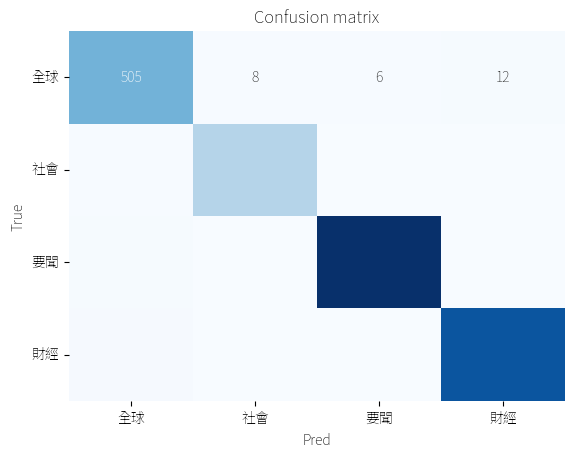

In [71]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

### 3.4 tfidf

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [72]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03893692, 0.        , 0.        , 0.08473503, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04536111, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [73]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.95      0.95      0.95       531
          社會       0.96      0.96      0.96       329
          要聞       0.99      0.99      0.99      1065
          財經       0.98      0.98      0.98       919

    accuracy                           0.98      2844
   macro avg       0.97      0.97      0.97      2844
weighted avg       0.98      0.98      0.98      2844



In [74]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 502,    9,    6,   14],
       [   4,  315,    6,    4],
       [  10,    2, 1052,    1],
       [  13,    1,    0,  905]], dtype=int64)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '全球'),
  Text(0, 1.5, '社會'),
  Text(0, 2.5, '要聞'),
  Text(0, 3.5, '財經')])

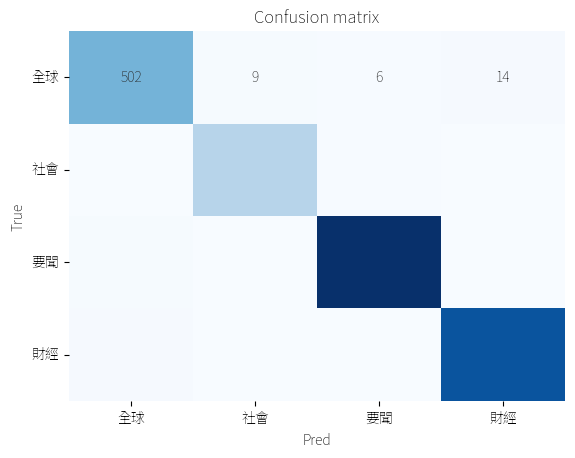

In [75]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

效果一樣也是不錯，可能因為四個新聞版別本來就有很大的差異，用字遣詞會不同。 
故可以有相似成效。

### 3.5 CV  

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。 

* figure1:  

![](images/grid_search_workflow.png) 

* figure 2:  

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

source: <https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection>

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [76]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.43218994, 0.41441441, 0.44489217, 0.47556067, 0.46201563]),
 'score_time': array([0.02951694, 0.03860545, 0.03772759, 0.02066541, 0.03549767]),
 'test_f1_macro': array([0.96217566, 0.95851597, 0.96323367, 0.95724346, 0.96322803]),
 'test_precision_macro': array([0.96489869, 0.95904738, 0.96293366, 0.96029635, 0.96539895]),
 'test_recall_macro': array([0.95978199, 0.95808068, 0.96357226, 0.95442199, 0.961133  ])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [77]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          全球       0.94      0.93      0.94      1264
          社會       0.96      0.94      0.95       767
          要聞       0.99      0.99      0.99      2485
          財經       0.97      0.98      0.97      2119

    accuracy                           0.97      6635
   macro avg       0.96      0.96      0.96      6635
weighted avg       0.97      0.97      0.97      6635



## 4. 比較不同模型效果

In [78]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          全球       0.94      0.93      0.94      1264
          社會       0.96      0.94      0.95       767
          要聞       0.99      0.99      0.99      2485
          財經       0.97      0.98      0.97      2119

    accuracy                           0.97      6635
   macro avg       0.96      0.96      0.96      6635
weighted avg       0.97      0.97      0.97      6635



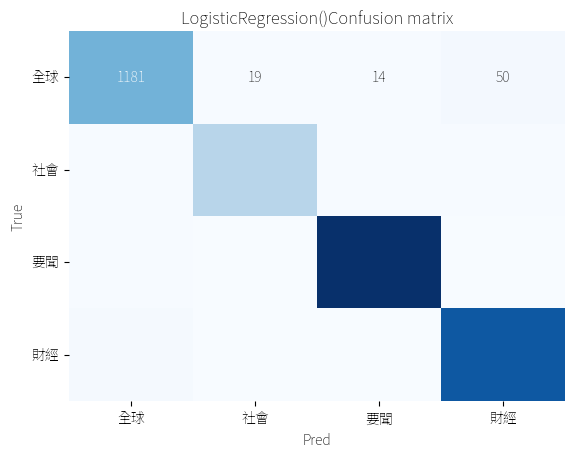

In [79]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

          全球       0.94      0.93      0.94      1264
          社會       0.96      0.94      0.95       767
          要聞       0.99      0.99      0.99      2485
          財經       0.97      0.98      0.97      2119

    accuracy                           0.97      6635
   macro avg       0.96      0.96      0.96      6635
weighted avg       0.97      0.97      0.97      6635

now training: clf_dtree
              precision    recall  f1-score   support

          全球       0.82      0.84      0.83      1264
          社會       0.86      0.84      0.85       767
          要聞       0.98      0.98      0.98      2485
          財經       0.94      0.93      0.94      2119

    accuracy                           0.92      6635
   macro avg       0.90      0.90      0.90      6635
weighted avg       0.92      0.92      0.92      6635

now training: clf_svm
              precision    recall  f1-score   support

  

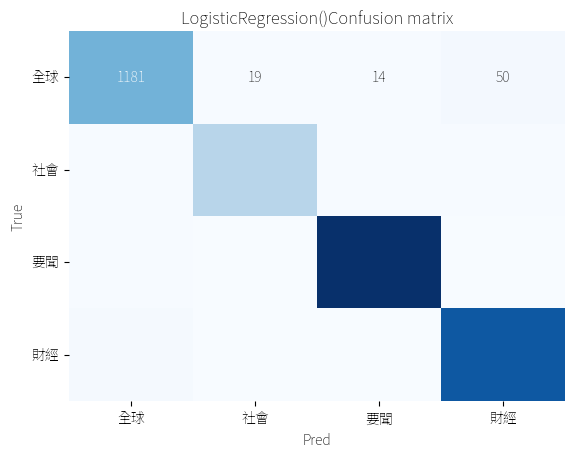

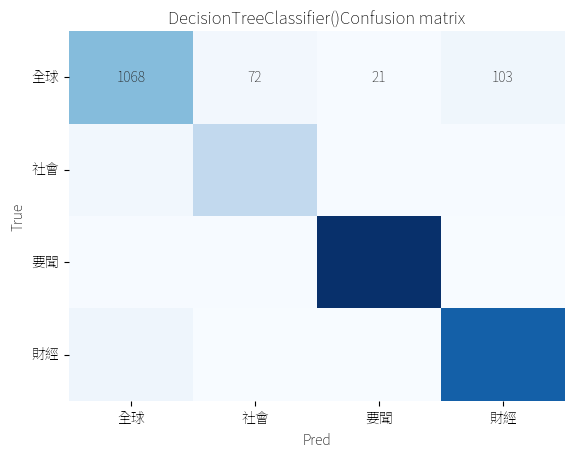

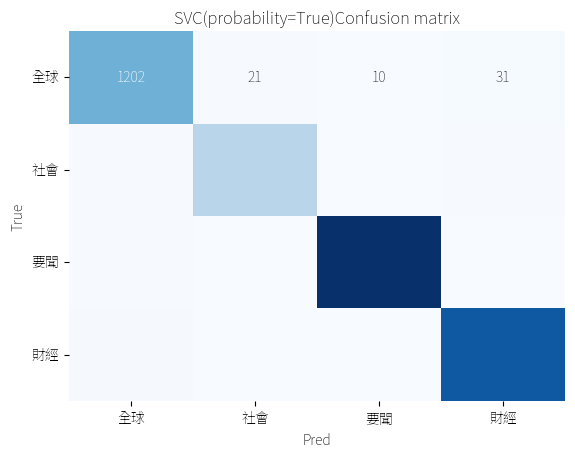

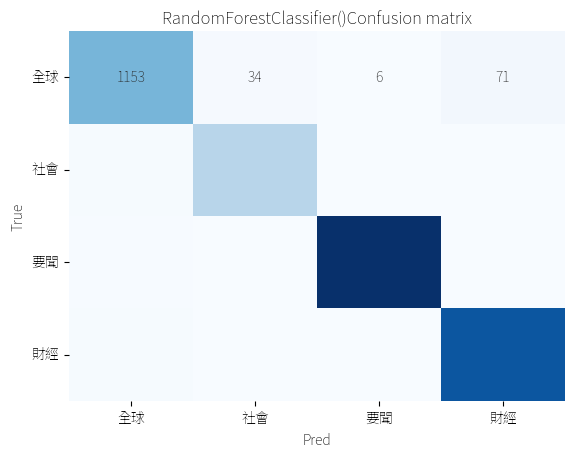

In [80]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

In [81]:
result_set['clf_logistic']

{'全球': {'precision': 0.938046068308181,
  'recall': 0.9343354430379747,
  'f1-score': 0.9361870788743558,
  'support': 1264},
 '社會': {'precision': 0.9588313413014609,
  'recall': 0.9413298565840938,
  'f1-score': 0.95,
  'support': 767},
 '要聞': {'precision': 0.9878983461073013,
  'recall': 0.9855130784708249,
  'f1-score': 0.9867042707493957,
  'support': 2485},
 '財經': {'precision': 0.965018656716418,
  'recall': 0.9764039641340255,
  'f1-score': 0.970677926342951,
  'support': 2119},
 'accuracy': 0.9677467972871138,
 'macro avg': {'precision': 0.9624486031083402,
  'recall': 0.9593955855567298,
  'f1-score': 0.9608923189916756,
  'support': 6635},
 'weighted avg': {'precision': 0.9677341059198936,
  'recall': 0.9677467972871138,
  'f1-score': 0.9677192323180328,
  'support': 6635}}

In [82]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'accuracy': 0.972871137905049,
 'macro avg': {'f1-score': 0.9659758396754389,
               'precision': 0.9666193696212928,
               'recall': 0.9653597265636197,
               'support': 6635},
 'weighted avg': {'f1-score': 0.9728747481058515,
                  'precision': 0.9728937074646966,
                  'recall': 0.972871137905049,
                  'support': 6635},
 '全球': {'f1-score': 0.9475758770201025,
        'precision': 0.9442262372348782,
        'recall': 0.9509493670886076,
        'support': 1264},
 '社會': {'f1-score': 0.9501312335958007,
        'precision': 0.9564068692206077,
        'recall': 0.9439374185136897,
        'support': 767},
 '要聞': {'f1-score': 0.9895287958115183,
        'precision': 0.9903264812575574,
        'recall': 0.9887323943661972,
        'support': 2485},
 '財經': {'f1-score': 0.976667452274334,
        'precision': 0.975517890772128,
        'recall': 0.9778197262859839,
        'support': 2119}}


In [83]:
y_pred = model_set['clf_svm'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.96      0.97      0.96       531
          社會       0.98      0.97      0.97       329
          要聞       0.99      0.99      0.99      1065
          財經       0.99      0.99      0.99       919

    accuracy                           0.98      2844
   macro avg       0.98      0.98      0.98      2844
weighted avg       0.98      0.98      0.98      2844



In [84]:
model_set['clf_svm'].predict(vectorizer.transform(["半導體 台積電 升值 金融"]).toarray())

array(['財經'], dtype=object)

* 最佳的 model 為 SVM，其中 Decision Tree 的表現較差外，其餘三個 model （Logistic、SVM、Random Forest）表現差不多。
* 另外也可以嘗試用直接的詞頻表作為 `vectorizer`，比較看看相較 tfidf，是否效果更好。

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

In [85]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

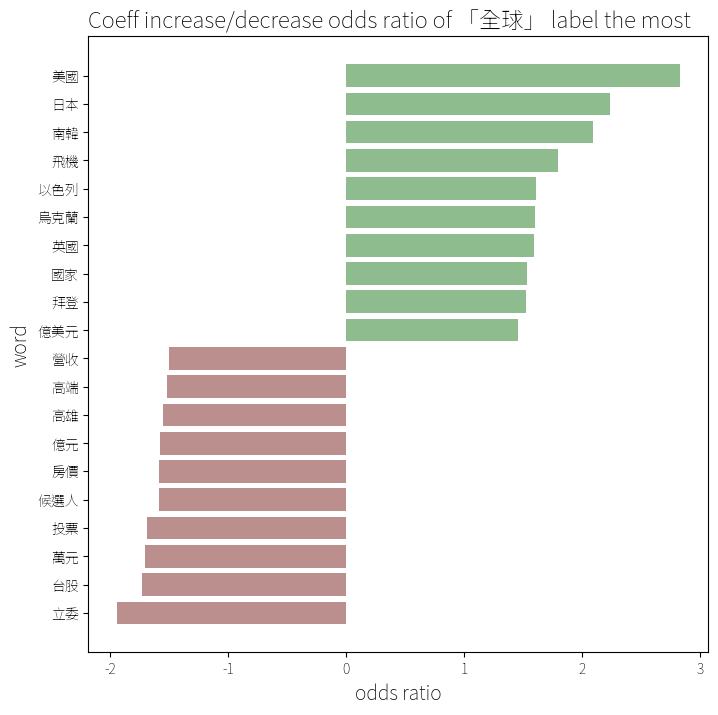

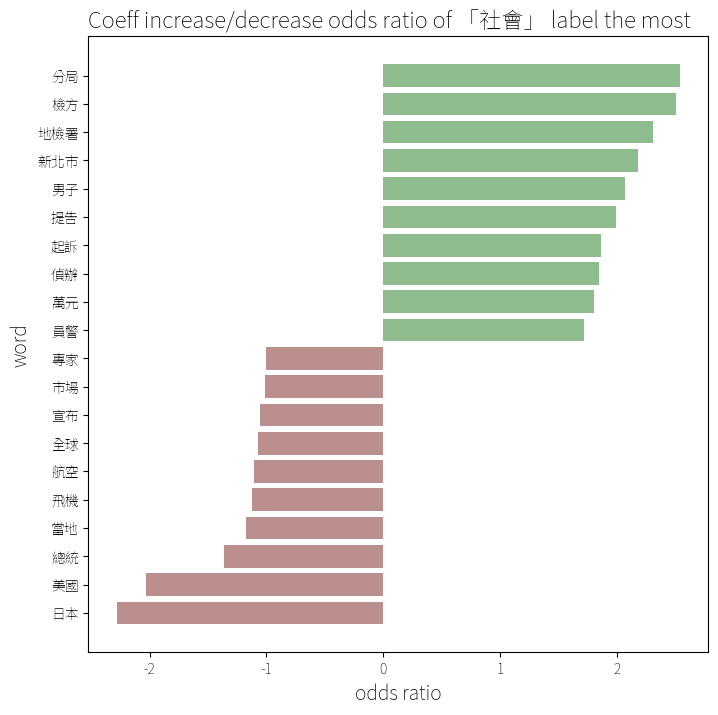

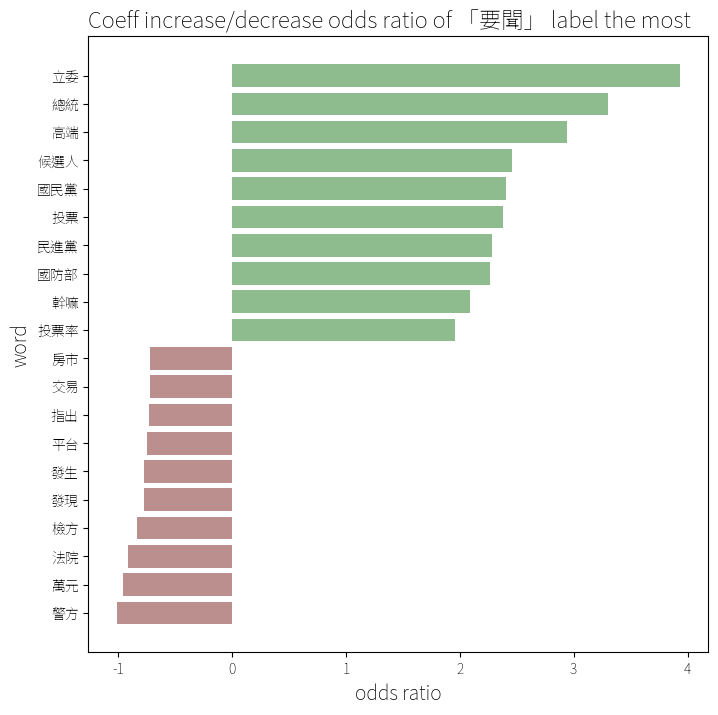

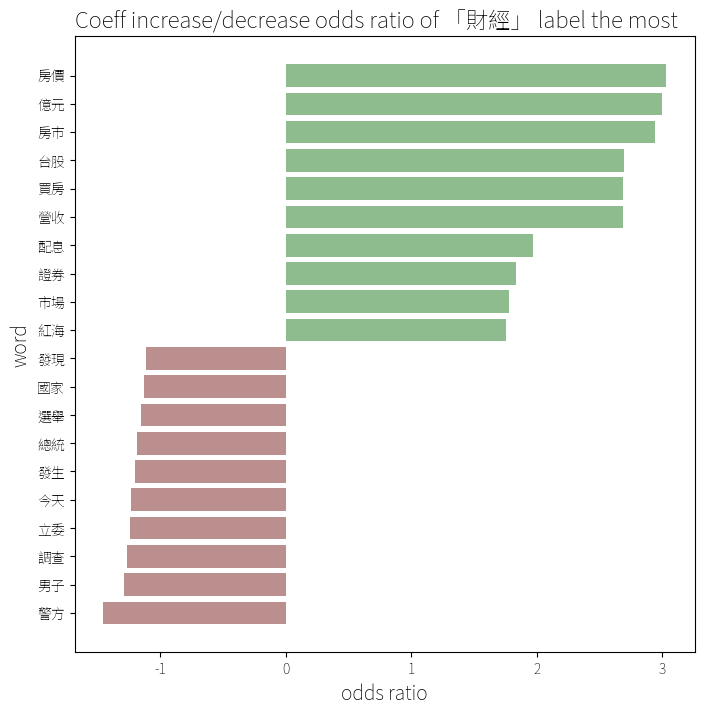

In [86]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

- 「全球」中出現了日本、美國、南韓還有飛機等國際新聞關鍵字，除了國家名稱外，也提到許多元首名稱，比較特殊的是，「飛機」這個詞語也被廣泛使用，經過查看資料發現國際新聞中常提到飛機相關的新聞，其中很多是描述共機擾台事件，此外還有關於日籍遊客輕航機失事等新聞。
- 「社會」中高係數的字是分局、檢方、地檢署等字詞，這些字詞通常出現在社會新聞中，例如檢方偵辦案件、地檢署提起公訴等相關新聞。此外，比較特殊是有提到「萬元」這個詞詞彙，經觀察資料，其出現在房價，以及罰鍰與獎金上。在此之上出現了「新北市」與「男子」，說明在此段時間內新北市的社會新聞中，有男子相關的社會案件。
- 「要聞」中高係數的字是立委、總統、高端與候選人，除了常見的政治相關詞彙外，我們發現有個看似不相干詞彙「幹嘛」，經觀察資料，發現這個詞彙幾乎都來自「政黨票能幹嘛？4神秘數字搶席次、領補助、還可扣稅」與「選民抱不平：幹嘛蹚這趟渾水？」等新聞，前者來自一個懶人包文字描述，後者則是來自一個影片的標題。
- 「財經」則是房市、億元、房價、營收與台股等相關詞彙，只會出現在財經相關新聞上，但是我發現「透天」這個詞彙也出現在財經新聞中，經觀察資料，發現該資料不僅出現在財經，也出現在多個新聞版面，因此我們決定將其加入停用字中。經過修改後，詞彙都更專注在財經術語上。

## 6. 預測新聞類別

`東森新聞.csv` 為東森新聞資料
- 版別：國際(world)、社會(society)、政治(politics)、財經(ec)
- 時間範圍：2023/12/23 ~ 2024/01/13
- 工作流程平台搜尋/排除關鍵字：無

In [87]:
ct = pd.read_csv("data/東森新聞.csv")
ct.dropna(inplace=True)
ct

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,她勞保多繳4年！少領近57萬 問題竟出在最後3年｜東森新聞,https://news.ebc.net.tw/news/article/397623,2023-12-24 10:59:00,財經,一名擁有26年年資的女性上班族，4年前離職退保，原本一次領可領169.46萬元，後來離職接案...,EBC
1,2,她薪水全丟這！存百萬竟遭18歲表弟嗆：不如阿公那輩｜東森新聞,https://news.ebc.net.tw/news/article/397656,2023-12-24 14:16:00,財經,面對低薪，除了斜槓，大家也會選擇投資。一名女網友表示，才高中的表弟嘲笑她只懂存錢，投資理財的...,EBC
2,3,陽明海運年終落差超嚴重！去年13個月 今年數字嚇死人｜東森新聞,https://news.ebc.net.tw/news/article/397802,2023-12-25 12:13:00,財經,在疫情期間，航運相關產業可以說是獲利頗豐，陽明海運在2022年的年終就高達13個月，羨煞不少...,EBC
3,4,勞保紓困貸款最高拿10萬元 申請4條件曝光！｜東森新聞,https://news.ebc.net.tw/news/article/397804,2023-12-25 13:02:00,財經,勞工快看過來！今（25）日，勞動部公告113年勞保紓困貸款將在1月5日開放申請，受理至113...,EBC
4,5,台塑四寶獲利衰！年終3.5個月恐無望 創11年低｜東森新聞,https://news.ebc.net.tw/news/article/397811,2023-12-25 13:51:00,財經,舞台上辣妹勁歌熱舞，炒熱現場氣氛，年底員工最期待的就是年終尾牙，不過傳產龍頭台塑集團，考量剛...,EBC
...,...,...,...,...,...,...,...
1775,1776,美英轟葉門叛軍 油價飆漲4％貨櫃運價連7漲｜東森新聞,https://news.ebc.net.tw/news/article/400727,2024-01-13 08:00:00,國際,美英聯軍12日針對葉門叛軍青年運動的73處目標，發射至少一百五十枚「戰斧」巡弋飛彈及雷射導引...,EBC
1776,1777,英相蘇納克二度訪烏 簽安全協議、增援近千億台幣｜東森新聞,https://news.ebc.net.tw/news/article/400730,2024-01-13 17:38:00,國際,俄烏開戰將近2年，但烏軍卻面臨外國軍援停擺的困境。不過近期繼日本外長訪烏，宣布撥款11.5億...,EBC
1777,1778,女扮遊戲角色「殭屍」搭陸地鐵遭攔 只因「引圍觀」｜東森新聞,https://news.ebc.net.tw/news/article/400734,2024-01-13 17:53:00,國際,女子頭戴紫色假髮，頂著殭屍帽，身穿類似漢服服裝，扮成殭屍要搭地鐵，卻被安檢員給攔了下來。地鐵...,EBC
1778,1779,大選影響台海情勢 日本防相：密切監視中國軍方｜東森新聞,https://news.ebc.net.tw/news/article/400768,2024-01-13 21:40:00,國際,台灣大選日本媒體也很關注，不只多家媒體記者來台連線採訪，甚至也在選前對三位候選人有所分析，但...,EBC


In [88]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,她勞保多繳4年！少領近57萬 問題竟出在最後3年｜東森新聞一名擁有26年年資的女性上班族，4...,https://news.ebc.net.tw/news/article/397623,財經,勞保 多繳 領近 57 問題 竟出 最後 東森 新聞 一名 擁有 26 年資 女性 上班族 ...
1,她薪水全丟這！存百萬竟遭18歲表弟嗆：不如阿公那輩｜東森新聞面對低薪，除了斜槓，大家也會選擇...,https://news.ebc.net.tw/news/article/397656,財經,薪水 百萬 18 表弟 阿公 那輩 東森 新聞 面對 低薪 斜槓 選擇 投資 一名 女網友 ...
2,陽明海運年終落差超嚴重！去年13個月 今年數字嚇死人｜東森新聞在疫情期間，航運相關產業可以說...,https://news.ebc.net.tw/news/article/397802,財經,陽明 海運 年終 落差 嚴重 去年 13 今年 數字 嚇死人 東森 新聞 疫情 期間 航運 ...
3,勞保紓困貸款最高拿10萬元 申請4條件曝光！｜東森新聞勞工快看過來！今（25）日，勞動部公告...,https://news.ebc.net.tw/news/article/397804,財經,勞保 貸款 最高 10 萬元 申請 條件 曝光 東森 新聞 勞工 過來 25 勞動部 公告 ...
4,台塑四寶獲利衰！年終3.5個月恐無望 創11年低｜東森新聞舞台上辣妹勁歌熱舞，炒熱現場氣氛，...,https://news.ebc.net.tw/news/article/397811,財經,台塑 四寶 獲利 年終 3.5 無望 11 東森 新聞 舞台 辣妹 勁歌熱舞 炒熱 現場 氣...


In [89]:
ct['artCatagory'].value_counts()

artCatagory
政治    660
社會    622
國際    451
財經     47
Name: count, dtype: int64

In [90]:
mapper = {"政治":"要聞", "國際":"全球", "社會":"社會", "財經":"財經"}
ct['artCatagory'] = ct['artCatagory'].map(mapper)

X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          全球       0.78      0.92      0.84       451
          社會       0.89      0.90      0.90       622
          要聞       0.99      0.86      0.92       660
          財經       0.57      0.55      0.56        47

    accuracy                           0.88      1780
   macro avg       0.81      0.81      0.80      1780
weighted avg       0.89      0.88      0.88      1780



全球、財經表現較差。

In [91]:
classes = clf.classes_
cm = confusion_matrix(y, y_pred)
cm

array([[414,  26,   4,   7],
       [ 54, 559,   3,   6],
       [ 42,  41, 570,   7],
       [ 20,   1,   0,  26]], dtype=int64)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '全球'),
  Text(0, 1.5, '社會'),
  Text(0, 2.5, '要聞'),
  Text(0, 3.5, '財經')])

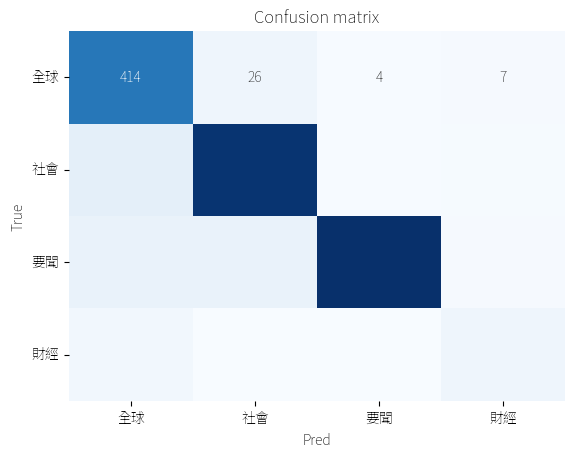

In [101]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False, annot_kws={"fontsize": 10})
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

In [93]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,勞保 多繳 領近 57 問題 竟出 最後 東森 新聞 一名 擁有 26 年資 女性 上班族 ...,財經,財經
1,薪水 百萬 18 表弟 阿公 那輩 東森 新聞 面對 低薪 斜槓 選擇 投資 一名 女網友 ...,財經,財經
2,陽明 海運 年終 落差 嚴重 去年 13 今年 數字 嚇死人 東森 新聞 疫情 期間 航運 ...,財經,全球
3,勞保 貸款 最高 10 萬元 申請 條件 曝光 東森 新聞 勞工 過來 25 勞動部 公告 ...,財經,財經
4,台塑 四寶 獲利 年終 3.5 無望 11 東森 新聞 舞台 辣妹 勁歌熱舞 炒熱 現場 氣...,財經,財經
...,...,...,...
1775,美英 葉門 叛軍 油價 飆漲 貨櫃 運價 東森 新聞 美英 聯軍 12 針對 葉門 叛軍 青...,全球,全球
1776,英相蘇 納克 二度 訪烏 安全 協議 增援 千億 台幣 東森 新聞 俄烏 開戰 面臨 外國 ...,全球,全球
1777,女扮 遊戲 角色 殭屍 陸地 鐵遭 圍觀 東森 新聞 女子 頭戴 紫色 假髮 頂著 殭屍 身...,全球,全球
1778,大選 影響 台海 情勢 日本 防相 密切 監視 中國軍方 東森 新聞 台灣 大選 日本 媒體...,全球,全球


In [94]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
2,陽明 海運 年終 落差 嚴重 去年 13 今年 數字 嚇死人 東森 新聞 疫情 期間 航運 ...,財經,全球
5,元老 振榮 辭世 業界 緬懷 生前 海派 人緣 東森 新聞 中鋼前 總經理 振榮 參與 公司...,財經,全球
10,美政府 維持 Apple Watch 進口 禁令 蘋果 上訴 東森 新聞 美國 總統 拜登 ...,財經,全球
13,東南亞 旅遊 注意 星馬 元旦 將調 消費稅 東森 新聞 打算 東南亞 旅遊 民眾 注意 新...,財經,全球
16,聯亞 生技 負責人 王長 怡傳 跳票 集團 財務狀況 引熱議 東森 新聞 聯亞 生技 集團 ...,財經,社會
...,...,...,...
1752,東京 旅館 挾持 持刀 扣押 人質 與警 對峙 小時 投降 東森 新聞 朝日 電視 記者 2...,全球,社會
1753,哈爾濱 網紅 企鵝 打卡 景點 遊客 互動 超萌 東森 新聞 見到 網紅 企鵝 淘淘 遊客 ...,全球,要聞
1756,命喪 柬埔寨 遺體 腫脹 陳屍 公寓 房間 搜出 白粉 東森 新聞 柬埔寨 首都 金邊 天空...,全球,社會
1762,房地產 排名 洗牌 央企 背景 保萬中 佔據 東森 新聞 大陸 房地產 巨頭 萬科 集團 創...,全球,財經


# 看錯誤預測的社會樣本

In [110]:
false_pred.loc[false_pred['artCatagory']=='社會', :].head(10)

,words,artCatagory,pred
719,金價 狂飆 他海削 逮竊遍 北宜 黃金 大盜 東森 新聞 年僅 20 男子 一身 黑衣 裝扮...,社會,全球
727,聚焦 真相 天坑 頻傳 工安 警訊 開挖 工程 危機 東森 新聞 國內 接二連三 發生 天坑...,社會,全球
735,海虎 潛艦 官兵 落海 失聯 家屬 淚崩 孩子 東森 新聞 海軍 艦隊 指揮部 海虎 潛艦 ...,社會,全球
740,公公 偷翻 媳婦 貼身衣物 愛才 嚇到 全身 東森 新聞 遇到 狀況 怎辦 近日 一位 人妻...,社會,全球
742,公安 申報 新北 稽查 密室 逃脫 全數 合格 東森 新聞 新北 市政府 這次 稽查 密室 ...,社會,財經
745,海虎艦 落海 搜救 已過 72 小時 海軍 延長 72 小時 東森 新聞 海虎 潛艦 意外 ...,社會,全球
765,聚焦 真相 獨家 專訪 運安會 調查 中捷 危機 處理 瑕疵 東森 新聞 捷運 一死 10 ...,社會,全球
788,女兒 CO 中毒 喪命 熱水器 裝不 通風 陽台 父遭 判刑 東森 新聞 天冷 使用 熱水器...,社會,財經
796,愛上 180 公分 羽球 女遭 拒竟 硬來 知道 東森 新聞 一名 潘姓 女子 愛上 身高 ...,社會,全球
805,先取 轉單 惡劣 外送員 二度 當歸鴨 偷餐 東森 新聞 頭戴 安全帽 身穿 雨衣 這名 送...,社會,全球


以其中一則新聞為例:

In [111]:
false_pred.loc[735, :]

words          海虎 潛艦 官兵 落海 失聯 家屬 淚崩 孩子 東森 新聞 海軍 艦隊 指揮部 海虎 潛艦 ...
artCatagory                                                   社會
pred                                                          全球
Name: 735, dtype: object

這篇社會版的文章被錯誤預測成全球的分類

In [112]:
pprint(false_pred['words'][735])

('海虎 潛艦 官兵 落海 失聯 家屬 淚崩 孩子 東森 新聞 海軍 艦隊 指揮部 海虎 潛艦 執勤 期間 發生 官兵 落海 事件 獲救 下落不明 搜救 '
 '進入 張姓 士官 家屬 表達 深切 哀傷 之情 士官 妻子 哭訴 兒子 不斷 哭泣 擔心 父親 受涼 回憶起 丈夫 承諾 會活 好好 丈夫 食言 盡快 '
 '回家 海軍 艦隊 指揮部 所轄 256 戰隊 海虎 軍艦 21 執勤 任務 未料 湧浪過 造成 官兵 落水 部分 獲救 下落不明 海軍 海巡 單位 積極 '
 '進行 搜救 時間 進入 尋獲 海軍 艦隊 指揮部 政戰 主任 林傳盛 少將 表示 海巡 巡護 號於 23 凌晨 12 15 小琉球 南方 海域 發現 '
 '一件 紅色 充氣 救生衣 救難 浮標 初步 判定 為海虎 潛艦 裝備 附近 發現 落海 官兵 士官 家屬 陷入 焦急 張妻 透露 兒子 一直 哭泣 擔心 '
 '父親 受寒 不斷 喊話 害怕 張妻 回憶起 丈夫 承諾 許多 計畫 包括 過年 櫻花 修船 沖繩 自由 萬聖節 六福村 遊玩 未來 20 退伍 夫妻 '
 '共同 計畫 哭喊 我會 捨不得你 你會活 好好 現在 開玩笑 張妻 句句 懇切 丈夫 食言 回家 透過 社群 媒體 表達 丈夫 思念 許多 網友 見狀 '
 '十分 心痛 紛紛 留言 安慰 期盼 搜救 團隊 早日 找到 失蹤 官兵 海軍 指部 表示 搜救 行動 進行 放棄 尋找 可能性 文章 來源 海虎 潛艦 '
 '官兵 落海 搜救 失聯 家屬 淚崩 孩子 害怕 CTWANT 授權 轉載')


全球相關詞彙，如「海軍」、「潛艦」、「官兵」、「失聯」等，可能是被推測成是國際戰爭的事件而被預測成是全球版

# 看錯誤預測的財經樣本

In [109]:
false_pred.loc[false_pred['artCatagory']=='財經', :].head(10)

,words,artCatagory,pred
2,陽明 海運 年終 落差 嚴重 去年 13 今年 數字 嚇死人 東森 新聞 疫情 期間 航運 ...,財經,全球
5,元老 振榮 辭世 業界 緬懷 生前 海派 人緣 東森 新聞 中鋼前 總經理 振榮 參與 公司...,財經,全球
10,美政府 維持 Apple Watch 進口 禁令 蘋果 上訴 東森 新聞 美國 總統 拜登 ...,財經,全球
13,東南亞 旅遊 注意 星馬 元旦 將調 消費稅 東森 新聞 打算 東南亞 旅遊 民眾 注意 新...,財經,全球
16,聯亞 生技 負責人 王長 怡傳 跳票 集團 財務狀況 引熱議 東森 新聞 聯亞 生技 集團 ...,財經,社會
19,聚焦 真相 財經專家 淪為 看板 詐騙 猖獗 解方 東森 新聞 現在 社群 平台 看到 財經...,財經,全球
21,Apple Pay 信用卡 到期 哀號 時間 還沒到 東森 新聞 近期 網友 表示 Appl...,財經,全球
25,30 Apple Watch 停售 東森 新聞 蘋果 旗下 智慧型 手錶 AppleWatc...,財經,全球
26,名人 論題 金河 失去 台灣 美國 霸權 終結 東森 新聞 金河 財信 傳媒 董事長 財訊 ...,財經,全球
28,日圓 升息 出現 甜甜 跌破 0.22 大關 東森 新聞 投資者 評估 日本 元旦 強震 日...,財經,全球


以其中一則新聞為例:

In [ ]:
false_pred.loc[10, :]

words          美政府 維持 Apple Watch 進口 禁令 蘋果 上訴 東森 新聞 美國 總統 拜登 ...
artCatagory                                                   財經
pred                                                          全球
Name: 10, dtype: object

In [ ]:
pprint(false_pred['words'][10])

('美政府 維持 Apple Watch 進口 禁令 蘋果 上訴 東森 新聞 美國 總統 拜登 政府 選擇 否決 專利 侵權 裁定 蘋果公司 Apple '
 '今天 表示 旗下 智慧 手錶 AppleWatch 最新型 號的 進口 禁令 提起 上訴 綜合 法新社 路透社 這項 針對 蘋果 最新 智慧 手錶 型號 '
 '禁令 今天 生效 AppleWatchSeries9 AppleWatchUltra2 無法 美國 實體 商店 或線 銷售 這項 禁令 大型 科技 公司 '
 '具有 價值 專利 展開 最新 法律 角力 谷歌 Google 針對 揚聲器 技術 Sonos 打官司 美國 國際貿易 委員會 ITC 10 裁定 禁止 '
 '進口 侵犯 一項 測定 血氧 含量 專利技術 蘋果 智慧 手錶 型號 這項 禁令 源起 Masimo 公司 2021 ITC 提出 申訴 這家 醫療 '
 '設備 製造商 指控 蘋果 侵犯 公司 感測 技術 測量 血氧 含量 專利 Masimo 這項 技術 發明 蘋果 挖角 員工 取得 技術 美國 貿易 代表 '
 'USTR 今天 聲明 指出 謹慎 商議 貿易 代表 戴琪 KatherineTai 決定 撤銷 ITC 這項 裁定 ITC 決定 2023 12 26 '
 '日成 最終 裁定 白宮 有權 撤銷 進口 禁令 狀況 鮮少 發生 蘋果 主張 ITC 裁決 錯誤 應予 撤銷 並向 美國聯邦 法院 提起 上訴 蘋果 '
 '發言人 表示 公司 針對 這項 禁令 華盛頓 美國聯邦 巡迴 上訴 法院 CourtofAppealsfortheFederalCircuit 提起 '
 '上訴 蘋果 今天 聲明 中說 強烈 同意 ITC 裁定 由此 產生 排除 命令 採取 措施 盡快 美國 顧客 恢復 供應 '
 'AppleWatchSeries9 AppleWatchUltra2 蘋果 請求 聯邦 巡迴 上訴 法院 暫停 禁令 至少 暫停 美國 海關 邊境 '
 '保護局 CBP 判定 重新 設計 過的 蘋果 智慧 手錶 型號 是否 侵犯 Masimo 專利 並在 法院 考慮 蘋果 請求 暫停 禁令 蘋果 美國 '
 '海關 邊境 保護局 預定 明年 12 做出 決定 耶誕 假期 前夕 蘋果 本月 21 已將 產品 自線 蘋果 商店

全球相關詞彙，如「美政府」、「美國」、「拜登」等。

模型對另一個新聞網的預測結果比較普通。可以看到財經與全球的 precision 都相對低。
- 另外三個版面均有不少文章被辨識成全球，推測全球涵蓋議題會比較多元，可能會有社會、政治、經濟等議題。像是上方例子提到海虎艦官兵落海事件，這樣的新聞可能會被辨識成全球。
- 也有不少財經被辨識成全球，推測是因為財經新聞中常提到國際經濟、國際股市等相關新聞。像是上方示例中提到美國與拜登政府等詞彙，這是全球新聞中常見的詞彙導致誤判。
- 因此推斷在東森新聞的資料中，全球新聞的內容可能比較多元，可能會有社會、政治、經濟等議題，因此在預測時會有一些誤判。

* accuracy可能會因為資料分布不同而有所偏差，所以評估模型的時候，可以加入一起 F1-score, recall, precision, AUC 等常見分類任務指標來評估。